In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.preprocessing.text import Tokenizer

In [6]:
#Miscellanous libraries
from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data = pd.read_csv('/content/drive/MyDrive/ kutub/OTT Content Reviews.xlsx - Sheet1 (1).csv')

data.head(10)

,Text,Label
0,"পুরাই অস্থির!!! ""সাকিল, চট্টগ্রাম",1
1,নাজিফা তুষি আপু অবিনয় টা বেস্ট ছিল ওনার জন্য ক...,1
2,পুরাই আগুন অনেক দিনের অপেক্ষায় আছি এই কাজ টা দ...,1
3,"ইন্টারেস্টিং স্টোরি,অভিনয়, সিনেমেটোগ্রাফিও জোস",1
4,এট লিস্ট অনন্ত জলীল এর ১০০ কোটি টাকার মুভির ট্...,1
5,এই গল্পে প্রচুর থ্রিল থাকবে কি হবে কি হবে এটা ...,1
6,নিখুঁত অভিনয়। এরকম সিরিজ তৈরি করলে দেশীয় কন্টে...,1
7,"চরকি মানেই ভিন্ন কিছু, আর সেটা যদি হয় আফরান নি...",1
8,অনেক ভালো মানের সিরিজ,1
9,আরফান নিশো ভাইয়ের নাটকের কাছে বাংলা ছায়াছবিও হ...,1


In [9]:
data.dropna(inplace=True)

In [10]:
print("Total Reviews:",len(data),
      "\nTotal Positive Reviews:",len(data[data.Label =='1']),
      "\nTotal Negative Reviews:",len(data[data.Label=='2']),
      "\nTotal Neutral Reviews:",len(data[data.Label =='0']))


Total Reviews: 5608 
Total Positive Reviews: 0 
Total Negative Reviews: 0 
Total Neutral Reviews: 0


In [11]:
data.columns

Index(['Text', 'Label'], dtype='object')

In [12]:
# print some unprocessed reviews
sample_data = [10,100,150,222,250,600,650,666,689,640,650,700,750,800,1000]
for i in sample_data:
      print(data.Text[i],'\n','Sentiment:-- ',data.Label[i],'\n')

আগুন লাগিয়ে দিলো এক ঝলকেই 
 Sentiment:--  0 

পুড়াই আগুন 
 Sentiment:--  1 

চঞ্চল চৌধুরী এবং সালাউদ্দিন লাভলু ধামাকা কিছু হবে অপেক্ষায় রইলাম ️️️ 
 Sentiment:--  1 

বাপরে বাপ! আগুন। দেখতে হবে। Another masterpiece will coming soon.. 
 Sentiment:--  1 

আমার কি প্রেম হবে না ১৮ বছর ধরে আমি সিঙ্গেল😞😞😞 
 Sentiment:--  0 

বাপরে আসলেই শ্বাসরুদ্ধকর ছিলো।এইটুকু দেখেই বোকের ভেতর ধড়পড় করছে জানিনা মুভিটা আরো কতোটা ভয়ংকর হবে।এই রকম মুভি আমার মতো দূর্বল চিত্তের মানুষের দেখা উচিত না। 
 Sentiment:--  1 

গল্প গুলা সুন্দর ছিল। বাংলায় এমন আরো অন্থরোলজি বানানো দরকার। 
 Sentiment:--  1 

পরিমনির কি চমৎকার আর সাবলীল অভিনয়। অভিনন্দন পরিমনি 
 Sentiment:--  1 

শ্যামল মাওলার কেনো ভয়েজ চেঞ্জ করা হয়েছে? 
 Sentiment:--  2 

শুরুতেই interest তৈরি হয়ে গেছে। 
 Sentiment:--  1 

গল্প গুলা সুন্দর ছিল। বাংলায় এমন আরো অন্থরোলজি বানানো দরকার। 
 Sentiment:--  1 

গল্পটা দারুন ছিল 
 Sentiment:--  1 

সর্বোচ্চ পর্যায়ের অভিনয় হয়েছে,,, ২০৭০ সালের জন্য রেখে গেলাম 
 Sentiment:--  1 

এই রকম কিছু দেখলে মনে হয়..যে দেশের মিড

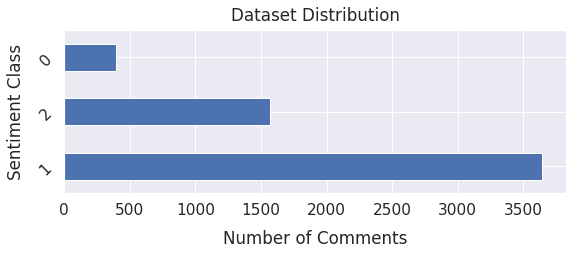

In [13]:
sns.set(font_scale=1.4)
data['Label'].value_counts().plot(kind='barh', figsize=(9, 3))
plt.xlabel("Number of Comments", labelpad=12)
plt.ylabel("Sentiment Class", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [14]:
!pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
     |████████████████████████████████| 23.9 MB 1.2 MB/s 
     |████████████████████████████████| 965 kB 56.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [15]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
import re

btokenizer = BasicTokenizer()

def clean_text(text):
    text = re.sub('[^\u0980-\u09FF]',' ',str(text))
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
data['cleaned'] = data.Text.apply(clean_text)

In [17]:
data

,Text,Label,cleaned
0,"পুরাই অস্থির!!! ""সাকিল, চট্টগ্রাম",1,পুরাই অস্থির সাকিল চট্টগ্রাম
1,নাজিফা তুষি আপু অবিনয় টা বেস্ট ছিল ওনার জন্য ক...,1,নাজিফা তুষি আপু অবিনয় টা বেস্ট ওনার কান্না আসছে
2,পুরাই আগুন অনেক দিনের অপেক্ষায় আছি এই কাজ টা দ...,1,পুরাই আগুন দিনের অপেক্ষায় আছি টা দেখার
3,"ইন্টারেস্টিং স্টোরি,অভিনয়, সিনেমেটোগ্রাফিও জোস",1,ইন্টারেস্টিং স্টোরি অভিনয় সিনেমেটোগ্রাফিও জোস
4,এট লিস্ট অনন্ত জলীল এর ১০০ কোটি টাকার মুভির ট্...,1,এট লিস্ট অনন্ত জলীল ১০০ টাকার মুভির ট্রেইলার হ...
...,...,...,...
5603,বউত অপেক্ষা গরির,1,বউত অপেক্ষা গরির
5604,জয় হোক চট্টগ্রামের সংস্কৃতির,1,জয় চট্টগ্রামের সংস্কৃতির
5605,এটা ভারতীয় কালচারে নোংরা ওয়েব সিরিজের অনুকরণ...,2,ভারতীয় কালচারে নোংরা ওয়েব সিরিজের অনুকরণ এগু...
5606,সিন্ডিকেটের প্রমোশনে এসে ফারিন আর তুষির এভাবে ...,2,সিন্ডিকেটের প্রমোশনে ফারিন তুষির এভাবে চরকির স...


In [18]:
# Apply the function into the dataframe
data['cleaned'] = data['Text'].apply(clean_text)  

# print some cleaned reviews from the dataset
sample_data = [10,100,25,854,966,1500,1589,1700,2000,2500,4000,4500]
for i in sample_data:
     print('Original:\n',data.Text[i],'\nCleaned:\n',
           data.cleaned[i],'\n','Sentiment:-- ',data.Label[i],'\n')

Original:
 আগুন লাগিয়ে দিলো এক ঝলকেই 
Cleaned:
 আগুন লাগিয়ে দিলো এক ঝলকেই 
 Sentiment:--  0 

Original:
 পুড়াই আগুন 
Cleaned:
 পুড়াই আগুন 
 Sentiment:--  1 

Original:
 অসাধারণ অভিনয় নিশো ভাই। 
Cleaned:
 অসাধারণ অভিনয় নিশো ভাই 
 Sentiment:--  1 

Original:
 দিঘির অভিনয় অনেক ভালো হইছে। আমারতো নাটকটা দেখতে ইচ্ছা করছে। 
Cleaned:
 দিঘির অভিনয় ভালো হইছে আমারতো নাটকটা ইচ্ছা 
 Sentiment:--  1 

Original:
 শুরু থেকে এই দেখছি এটা তবে একটু ভালো থাকি আর বেশি সময় খারাপ থাকি মানে এটা দেখে মন খারাপ হয় আর কি। ১০৪ পর্ব দেখে আর সহ্য করতে পারি নি।যদিও এটা নাটক তার পরে ও কেমন যে একটা ব্যাথা।মনে হয় বাস্তবতা 
Cleaned:
 দেখছি একটু ভালো থাকি সময় খারাপ থাকি মানে মন খারাপ ১০৪ পর্ব সহ্য নি নাটক কেমন একটা ব্যাথা বাস্তবতা 
 Sentiment:--  1 

Original:
 সর্ব কালের শ্রেষ্ঠ। তাই উনি মহানায়ক। ধরিত্রীর বুকে এত ভাল অভিনেতা আর কোনদিন জন্মাবে না। বাংলা চলচ্চিত্র জগতে ওনার সামনে সকলেই ম্লান। 
Cleaned:
 সর্ব কালের শ্রেষ্ঠ মহানায়ক ধরিত্রীর বুকে ভাল অভিনেতা কোনদিন জন্মাবে বাংলা চলচ্চিত্র জগতে ওনার সকলেই ম্লান 
 Sentiment:-- 

In [19]:
data

,Text,Label,cleaned
0,"পুরাই অস্থির!!! ""সাকিল, চট্টগ্রাম",1,পুরাই অস্থির সাকিল চট্টগ্রাম
1,নাজিফা তুষি আপু অবিনয় টা বেস্ট ছিল ওনার জন্য ক...,1,নাজিফা তুষি আপু অবিনয় টা বেস্ট ওনার কান্না আসছে
2,পুরাই আগুন অনেক দিনের অপেক্ষায় আছি এই কাজ টা দ...,1,পুরাই আগুন দিনের অপেক্ষায় আছি টা দেখার
3,"ইন্টারেস্টিং স্টোরি,অভিনয়, সিনেমেটোগ্রাফিও জোস",1,ইন্টারেস্টিং স্টোরি অভিনয় সিনেমেটোগ্রাফিও জোস
4,এট লিস্ট অনন্ত জলীল এর ১০০ কোটি টাকার মুভির ট্...,1,এট লিস্ট অনন্ত জলীল ১০০ টাকার মুভির ট্রেইলার হ...
...,...,...,...
5603,বউত অপেক্ষা গরির,1,বউত অপেক্ষা গরির
5604,জয় হোক চট্টগ্রামের সংস্কৃতির,1,জয় চট্টগ্রামের সংস্কৃতির
5605,এটা ভারতীয় কালচারে নোংরা ওয়েব সিরিজের অনুকরণ...,2,ভারতীয় কালচারে নোংরা ওয়েব সিরিজের অনুকরণ এগু...
5606,সিন্ডিকেটের প্রমোশনে এসে ফারিন আর তুষির এভাবে ...,2,সিন্ডিকেটের প্রমোশনে ফারিন তুষির এভাবে চরকির স...


In [20]:
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))

# Remove the reviews with least words
dataset = data.loc[data.length>2]
dataset = data.reset_index(drop = True)

In [21]:
print("After Cleaning:","\nRemoved {} Small Reviews".format(len(data)-len(dataset)),
      "\nTotal Reviews:",len(dataset))

After Cleaning: 
Removed 0 Small Reviews 
Total Reviews: 5608


In [22]:
print("Maximum Length of a Review:",max(dataset.length))
print("Minimum Length of a Review:", min(dataset.length))
print("Average Length of a Review:",round(np.mean(dataset.length),0))

Maximum Length of a Review: 153
Minimum Length of a Review: 0
Average Length of a Review: 8.0


In [23]:
dataset=dataset[['cleaned','Label']]
dataset.head(5)

,cleaned,Label
0,পুরাই অস্থির সাকিল চট্টগ্রাম,1
1,নাজিফা তুষি আপু অবিনয় টা বেস্ট ওনার কান্না আসছে,1
2,পুরাই আগুন দিনের অপেক্ষায় আছি টা দেখার,1
3,ইন্টারেস্টিং স্টোরি অভিনয় সিনেমেটোগ্রাফিও জোস,1
4,এট লিস্ট অনন্ত জলীল ১০০ টাকার মুভির ট্রেইলার হ...,1


In [24]:
#Dataset Summary

def data_summary(dataset):
    
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.Label.value_counts().to_dict().items()]
  # find word list
    for label in class_label: 
        word_list = [word.strip() for t in list(dataset[dataset.Label==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
                
        # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        
        # Documents per class
        documents.append(len(list(dataset[dataset.Label==label].cleaned)))
        
        # Total Word per class
        words.append(len(word_list))
        
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.Label==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
                
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))           
   
    return documents,words,u_words,class_label


documents,words,u_words,class_names = data_summary(dataset)   


Class Name :  1
Number of Documents:3645
Number of Words:27103
Number of Unique Words:6242
Most Frequent Words:

ভালো	649
অসাধারণ	601
গান	405
সুন্দর	398
একটা	337
টা	277
অভিনয়	263
নাটক	197
গানটা	184
এক	181

Class Name :  2
Number of Documents:1570
Number of Words:12884
Number of Unique Words:5153
Most Frequent Words:

ভালো	178
একটা	127
এসব	84
অভিনয়	81
টা	75
সিনেমা	66
সিরিজ	64
ছবি	60
ফালতু	59
বাজে	59

Class Name :  0
Number of Documents:393
Number of Words:2604
Number of Unique Words:1471
Most Frequent Words:

টা	27
ভালো	25
নাম	24
ভাই	23
একটা	23
চাই	21
নাটক	16
সাথে	15
মুভি	13
যায়	12
Total Number of Unique Words:9980


In [25]:
#dataset['label']=dataset['label'].replace({'positive':1,'negative':0,'neutral':2})
#dataset.head()

In [26]:
#labels=dataset.label
#labels

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf1 = TfidfVectorizer(ngram_range=(1,1),use_idf=True,tokenizer=lambda x: x.split()) 
X = tfidf1.fit_transform(dataset['cleaned'])
y=dataset['Label']
print("Shape of TF-IDF:",X.shape,'\n')

Shape of TF-IDF: (5608, 9980) 



In [28]:
y

0       1
1       1
2       1
3       1
4       1
       ..
5603    1
5604    1
5605    2
5606    2
5607    2
Name: Label, Length: 5608, dtype: int64

In [29]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot

In [30]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

Class=1, n=3645 (33.333%)
Class=0, n=3645 (33.333%)
Class=2, n=3645 (33.333%)


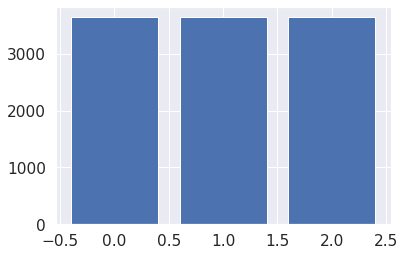

In [31]:
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [32]:
review='পুরাই অস্থির সাকিল চট্টগ্রাম	'
print("Sample Review: ",review)
vector = tfidf1.transform([review])
df = pd.DataFrame(vector.T.todense(), index=tfidf1.get_feature_names(), columns=["tfidf"])
a = df.sort_values(by=["tfidf"],ascending=False)
print(a[0:len(review.split())])

Sample Review:  পুরাই অস্থির সাকিল চট্টগ্রাম	
              tfidf
সাকিল      0.554897
চট্টগ্রাম  0.554897
অস্থির     0.465944
পুরাই      0.408749


In [33]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(X,y,train_size = 0.8, test_size = 0.2,random_state =500)

print('Shape of X_train:', xtrain.shape)
print('Shape of X_test:', xtest.shape)
print('Shape of Y_train:', ytrain.shape)
print('Shape of Y_test:', ytest.shape)

Shape of X_train: (8748, 9980)
Shape of X_test: (2187, 9980)
Shape of Y_train: (8748,)
Shape of Y_test: (2187,)


In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [35]:
mn= MultinomialNB()
mn.fit(xtrain, ytrain)
prediction = mn.predict(xtest)
pred_prob1 = mn.predict_proba(xtest)
print("Accuracy: {0:.2%}".format(accuracy_score(prediction, ytest)))

Accuracy: 89.57%


In [36]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(ytest, prediction))


Classification Report

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       693
           1       0.92      0.83      0.87       763
           2       0.92      0.88      0.90       731

    accuracy                           0.90      2187
   macro avg       0.90      0.90      0.90      2187
weighted avg       0.90      0.90      0.90      2187



In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

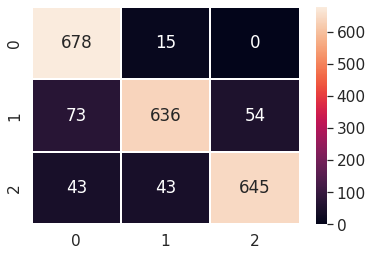

In [38]:
conf_m = confusion_matrix(ytest, prediction)
sns.heatmap(conf_m, linewidths=1, annot=True, fmt='g')

In [39]:
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

In [40]:
fpr = {}
tpr = {}
thresh ={}
n_class = 3

In [41]:
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(ytest, pred_prob1[:,i], pos_label=i)

In [42]:
pred_prob1 = mn.predict_proba(xtest)[:,1]

In [43]:
fpr1 , tpr1, thresholds1 =metrics.roc_curve(ytest, pred_prob1,pos_label=1)

In [44]:
knn= KNeighborsClassifier(n_neighbors=3, metric = 'minkowski')
knn.fit(xtrain, ytrain)
prediction = knn.predict(xtest)
pred_prob2 = knn.predict_proba(xtest)
print("Accuracy: {0:.2%}".format(accuracy_score(prediction, ytest)))

Accuracy: 78.51%


In [45]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(ytest, prediction))


Classification Report

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       693
           1       0.78      0.55      0.64       763
           2       0.67      0.84      0.75       731

    accuracy                           0.79      2187
   macro avg       0.79      0.79      0.78      2187
weighted avg       0.79      0.79      0.78      2187



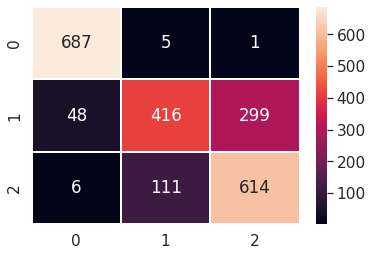

In [46]:
conf_m = confusion_matrix(ytest, prediction)
sns.heatmap(conf_m, linewidths=1, annot=True, fmt='g')

In [47]:
pred_prob2 = knn.predict_proba(xtest)[:,1]
fpr2 , tpr2, thresholds2 =metrics.roc_curve(ytest, pred_prob2,pos_label=1)

In [48]:
lsvm= SVC(kernel="linear", probability=True)
lsvm.fit(xtrain, ytrain)
prediction = lsvm.predict(xtest)
pred_prob3 = lsvm.predict_proba(xtest)
print("Accuracy: {0:.2%}".format(accuracy_score(prediction, ytest)))

Accuracy: 92.14%


In [49]:
print('\nClassification Report\n')
print(classification_report(ytest, prediction))


Classification Report

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       693
           1       0.95      0.84      0.89       763
           2       0.88      0.94      0.91       731

    accuracy                           0.92      2187
   macro avg       0.92      0.92      0.92      2187
weighted avg       0.92      0.92      0.92      2187



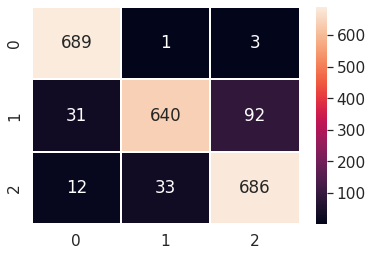

In [50]:
conf_m = confusion_matrix(ytest, prediction)
sns.heatmap(conf_m, linewidths=1, annot=True, fmt='g')

In [51]:
pred_prob3 = mn.predict_proba(xtest)[:,1]
fpr3 , tpr3, thresholds3 =metrics.roc_curve(ytest, pred_prob3,pos_label=1)

In [52]:
ksvm= SVC(kernel = 'rbf',probability=True)
ksvm.fit(xtrain, ytrain)
prediction = ksvm.predict(xtest)
pred_prob4 = ksvm.predict_proba(xtest)
print("Accuracy: {0:.2%}".format(accuracy_score(prediction, ytest)))

Accuracy: 93.14%


In [53]:
print('\nClassification Report\n')
print(classification_report(ytest, prediction))


Classification Report

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       693
           1       0.87      0.95      0.91       763
           2       0.95      0.86      0.91       731

    accuracy                           0.93      2187
   macro avg       0.94      0.93      0.93      2187
weighted avg       0.93      0.93      0.93      2187



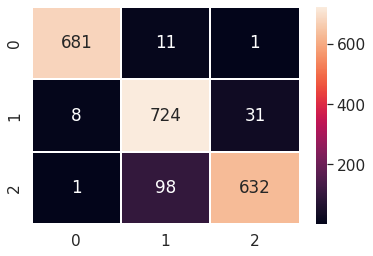

In [54]:
conf_m = confusion_matrix(ytest, prediction)
sns.heatmap(conf_m, linewidths=1, annot=True, fmt='g')

In [55]:
pred_prob4 = ksvm.predict_proba(xtest)[:,1]
fpr4 , tpr4, thresholds4 =metrics.roc_curve(ytest, pred_prob4,pos_label=1)

In [56]:
dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)
prediction = dt.predict(xtest)
pred_prob5 = dt.predict_proba(xtest)
print("Accuracy: {0:.2%}".format(accuracy_score(prediction, ytest)))

Accuracy: 85.64%


In [57]:
print('\nClassification Report\n')
print(classification_report(ytest, prediction))


Classification Report

              precision    recall  f1-score   support

           0       0.88      0.95      0.92       693
           1       0.81      0.82      0.82       763
           2       0.88      0.80      0.84       731

    accuracy                           0.86      2187
   macro avg       0.86      0.86      0.86      2187
weighted avg       0.86      0.86      0.86      2187



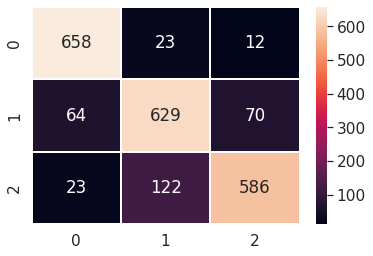

In [58]:
conf_m = confusion_matrix(ytest, prediction)
sns.heatmap(conf_m, linewidths=1, annot=True, fmt='g')

In [59]:
pred_prob5 = dt.predict_proba(xtest)[:,1]
fpr5 , tpr5, thresholds5 =metrics.roc_curve(ytest, pred_prob5,pos_label=1)

In [60]:
rf = RandomForestClassifier(n_estimators=100, criterion ='entropy', random_state = 0)
rf.fit(xtrain, ytrain)
prediction = rf.predict(xtest)
pred_prob6 = rf.predict_proba(xtest)
print("Accuracy: {0:.2%}".format(accuracy_score(prediction, ytest)))


Accuracy: 90.49%


In [61]:
print('\nClassification Report\n')
print(classification_report(ytest, prediction))


Classification Report

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       693
           1       0.84      0.90      0.87       763
           2       0.92      0.85      0.88       731

    accuracy                           0.90      2187
   macro avg       0.91      0.91      0.91      2187
weighted avg       0.91      0.90      0.91      2187



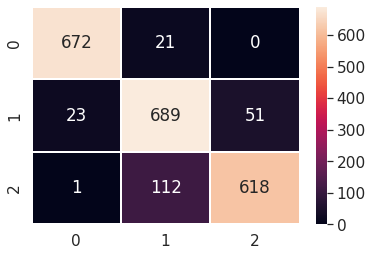

In [62]:
conf_m = confusion_matrix(ytest, prediction)
sns.heatmap(conf_m, linewidths=1, annot=True, fmt='g')

In [63]:
pred_prob6 = rf.predict_proba(xtest)[:,1]
fpr6 , tpr6, thresholds6 =metrics.roc_curve(ytest, pred_prob6,pos_label=1)

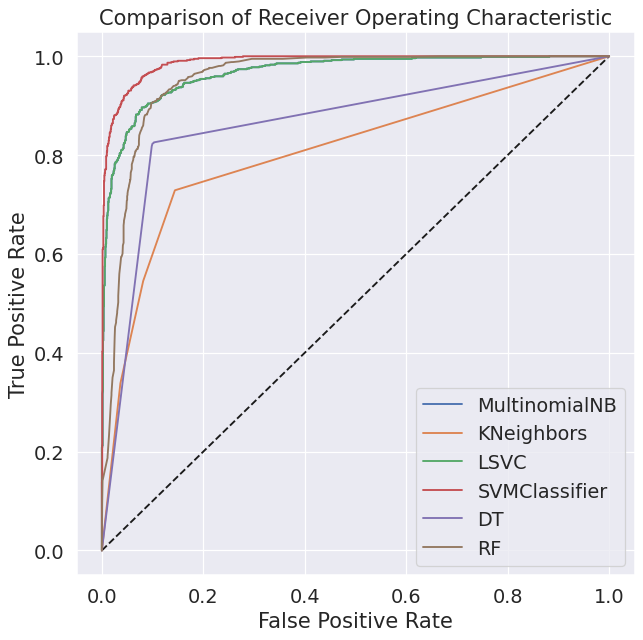

In [64]:
plt.figure(figsize=(8, 8), dpi=90)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "MultinomialNB" )
plt.plot(fpr2, tpr2, label= "KNeighbors" )
plt.plot(fpr3, tpr3, label= "LSVC" )
plt.plot(fpr4, tpr4, label= "SVMClassifier")
plt.plot(fpr5, tpr5, label= "DT")
plt.plot(fpr6, tpr6, label= "RF")


plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Comparison of Receiver Operating Characteristic')
plt.show()